# MODIS 8 day LST image selection code
The aim of this code is to examine the images and pick those which have a good number of useable pixels
1. select the image
2. find the lat lon grid and subset which contains the city and the surrounding area
3. extract the QC flags for the relevent area
4. investigate the bits (good quality is those with bits 1 and 0 both equal to 0)
5. find number of bits which are bad quality
6. add filename to the chosen file list if the image quality is good
7. save the file list as a pickle and return the percentage of files which have good images

In [52]:
# Import packages
import os
import re  # regular expressions
import pathlib
import warnings
import gdal
import matplotlib.pyplot as plt
from matplotlib import ticker # for setting y axis to integers
from matplotlib.ticker import MaxNLocator
import numpy as np
import numpy.ma as ma
import rasterio as rio
from rasterio.plot import plotting_extent
import geopandas as gpd
import earthpy as et
import earthpy.plot as ep
import earthpy.spatial as es
import earthpy.mask as em
import pandas as pd
import pyproj
from pyhdf.SD import SD, SDC
import datetime as dt
import scipy
from scipy import interpolate
import pickle

warnings.simplefilter('ignore')

#Define functions for bit flag interpretation
#bit flag interpretation
#Defining QC functions
#function to check the status of a byte on the QC control
def check_bits(x,n):
    if (x & (1<<n)): 
  ## n-th bit is 1 
        flag = 1
    else:
  ## n-th bit is 0
        flag = 0
    return flag

#function to check bytes 1 and 2 and return 0 if they are both 0
def quality_control(x):
    if ((check_bits(x,1) == 0) and (check_bits(x,2) == 0)):
  ##if bit 1 and bit 2 are 0 then 0 
        flag = 0
    else:
  ##otherwise flag is 1
        flag = 1
    return flag    

#load in csv of city lons and lats
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT'))
CITY_COUNTRY_lat_lon = pd.read_excel('CITY_COUNTRY_lat_lon.xlsx', index_col=0)

In [53]:
#Manual entries
CITY_COUNTRY = "ASYUT_EGYPT"
#SATELLITE = 'MOD11A2' #TERRA
SATELLITE = 'MYD11A2' #AQUA

#set the fraction of pixels which make the image unusable (if there is a greater number of pixels then this of bad quality, 
#image will not be used)
unusable_cutoff = 0.3

In [54]:
# Set working directory
#MOD11A2 is terra
#MYD11A2 is aqua

#set the city latitude and longitudes and city name
City_Lat = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['CITY_COUNTRY'] == CITY_COUNTRY]['Lat'][0]
City_Lon = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['CITY_COUNTRY'] == CITY_COUNTRY]['Lon'][0]
City_name = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['CITY_COUNTRY'] == CITY_COUNTRY]['City'][0]

#create satellite name for plots
if SATELLITE == 'MOD11A2':
    satellite_name = 'Terra'
else:
    satellite_name = 'Aqua'

#Set path
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT', 'MODIS_8_day_LST', CITY_COUNTRY, SATELLITE))
#set path to current directory
path = pathlib.Path().absolute()

#Create a list of the hdf files in the current directory
hdfs = []
for root, dirs, files in os.walk(path):
    for file in files:
        if file.endswith('.hdf'):
            hdfs.append(file)
            
            
#Area to look at will be the city centre +/- 0.25 degs?
min_lat = City_Lat - 0.25
max_lat = City_Lat + 0.25
min_lon = City_Lon - 0.25
max_lon = City_Lon + 0.25

In [55]:
#Create the coordinate grid for the image

DATAFIELD_NAME = 'QC_Day'
#need to also look at 'QC_Night', but as grid is same for both doesn't matter
GRID_NAME = 'MODIS_Grid_8Day_1km_LST'

#Create empty lists to be filled with filenames
Day_list = []
Night_list = []

for i in range(len(hdfs)):
    file_name = hdfs[i]
    hdf = SD(file_name, SDC.READ)

    # Read dataset.
    data2D = hdf.select(DATAFIELD_NAME)
    data = data2D[:,:].astype(np.float64)

    # Read global attribute.
    fattrs = hdf.attributes(full=1)
    ga = fattrs["StructMetadata.0"]
    gridmeta = ga[0]

    # Construct the grid.  The needed information is in global attribute 'StructMetadata.0'
    # Use regular expressions (re) to find the extents of the grid in metadata

    ul_regex = re.compile(r'''UpperLeftPointMtrs=\(
                                      (?P<upper_left_x>[+-]?\d+\.\d+)
                                      ,
                                      (?P<upper_left_y>[+-]?\d+\.\d+)
                                      \)''', re.VERBOSE)
    match = ul_regex.search(gridmeta)
    x0 = np.float(match.group('upper_left_x')) 
    y0 = np.float(match.group('upper_left_y')) 
    
    lr_regex = re.compile(r'''LowerRightMtrs=\(
                                      (?P<lower_right_x>[+-]?\d+\.\d+)
                                      ,
                                        (?P<lower_right_y>[+-]?\d+\.\d+)
                                      \)''', re.VERBOSE)
    match = lr_regex.search(gridmeta)
    x1 = np.float(match.group('lower_right_x')) 
    y1 = np.float(match.group('lower_right_y')) 
    ny, nx = data.shape
    xinc = (x1 - x0) / nx
    yinc = (y1 - y0) / ny

    x = np.linspace(x0, x0 + xinc*nx, nx)
    y = np.linspace(y0, y0 + yinc*ny, ny)
    xv, yv = np.meshgrid(x, y)

    # convert the grid back to lat/lons.
    sinu = pyproj.Proj("+proj=sinu +R=6371007.181 +nadgrids=@null +wktext")
    wgs84 = pyproj.Proj("+init=EPSG:4326") 
    lon, lat= pyproj.transform(sinu, wgs84, xv, yv)

    #Extract the QC_day subset

    data_path = os.path.join(file_name)


    #QC day      
    with rio.open(data_path) as dataset:
        # Loop through each subdataset in HDF4 file
        for name in dataset.subdatasets:
        
            # Use regular expression to identify if subdataset has LST:QC_Day in the name
            if re.search("LST:QC_Day*", name):
        
                # Open the band subdataset
                with rio.open(name) as subdataset:
                    modis_meta = subdataset.profile
                
                    # Read band data as a 2 dim arr and append to list
                    QC_day = subdataset.read(1)   
                
                
    #Extract the QC_night subset

    #QC day      
    with rio.open(data_path) as dataset:
        # Loop through each subdataset in HDF4 file
        for name in dataset.subdatasets:
        
            # Use regular expression to identify if subdataset has LST:QC_Night in the name
            if re.search("LST:QC_Night*", name):
        
                # Open the band subdataset
                with rio.open(name) as subdataset:
                    modis_meta = subdataset.profile
                
                    # Read band data as a 2 dim arr and append to list
                    QC_night = subdataset.read(1)   



    #Create of data frame of QC and coordinates

    QC_day_list = QC_day.flatten()
    QC_night_list = QC_night.flatten()
    lon_list = lon.flatten()
    lat_list = lat.flatten()

    df = pd.DataFrame(list(zip(QC_day_list, QC_night_list, lon_list, lat_list)), 
                   columns =['QC_day', 'QC_night', 'Longitude','Latitude']) 

    df_subset = df[(df.Latitude >min_lat) & (df.Latitude < max_lat) & (df.Longitude > min_lon) & (df.Longitude < max_lon)]

    QC_day_list_subset = df_subset["QC_day"].values
    QC_night_list_subset = df_subset["QC_night"].values
    
    QC_Day_2 = np.array([quality_control(int(i)) for i in QC_day_list_subset])
    QC_Night_2 = np.array([quality_control(int(i)) for i in QC_night_list_subset])

    Day_fract_unusable = sum(QC_Day_2)/ len(QC_Day_2)
    Night_fract_unusable = sum(QC_Night_2)/ len(QC_Night_2)


    if Day_fract_unusable < unusable_cutoff:
        Day_list.append(file_name)
    
    if Night_fract_unusable < unusable_cutoff:
        Night_list.append(file_name)
    

#Save to pickles
with open('Day_list.pkl', 'wb') as f:
    pickle.dump(Day_list, f)
    
with open('Night_list.pkl', 'wb') as f:
    pickle.dump(Night_list, f)
    
print('Percent of quality images: Day', 100*len(Day_list)/len(hdfs))
print('Percent of quality images: Night', 100*len(Night_list)/len(hdfs))

Percent of quality images: Day 100.0
Percent of quality images: Night 100.0


In [56]:
#Total number of images
len(hdfs)

848

In [57]:
#Read pickle files back in 
with open('Day_list.pkl', 'rb') as f:
    Day_list = pickle.load(f)
    
with open('Night_list.pkl', 'rb') as f:
    Night_list = pickle.load(f)

In [58]:
Day_list

['MYD11A2.A2002185.h20v06.006.2015146152639.hdf',
 'MYD11A2.A2002193.h20v06.006.2015146152941.hdf',
 'MYD11A2.A2002201.h20v06.006.2015146153313.hdf',
 'MYD11A2.A2002209.h20v06.006.2015152152811.hdf',
 'MYD11A2.A2002217.h20v06.006.2015149013859.hdf',
 'MYD11A2.A2002225.h20v06.006.2015149090935.hdf',
 'MYD11A2.A2002233.h20v06.006.2015149173017.hdf',
 'MYD11A2.A2002241.h20v06.006.2015150015146.hdf',
 'MYD11A2.A2002249.h20v06.006.2015150080002.hdf',
 'MYD11A2.A2002257.h20v06.006.2015152225446.hdf',
 'MYD11A2.A2002265.h20v06.006.2015160195429.hdf',
 'MYD11A2.A2002273.h20v06.006.2015161034434.hdf',
 'MYD11A2.A2002281.h20v06.006.2015161121557.hdf',
 'MYD11A2.A2002289.h20v06.006.2015161231441.hdf',
 'MYD11A2.A2002297.h20v06.006.2015162095546.hdf',
 'MYD11A2.A2002305.h20v06.006.2015162204412.hdf',
 'MYD11A2.A2002313.h20v06.006.2015163144149.hdf',
 'MYD11A2.A2002321.h20v06.006.2015163212723.hdf',
 'MYD11A2.A2002329.h20v06.006.2015164043036.hdf',
 'MYD11A2.A2002337.h20v06.006.2015166155206.hdf',


In [59]:
Night_list

['MYD11A2.A2002185.h20v06.006.2015146152639.hdf',
 'MYD11A2.A2002193.h20v06.006.2015146152941.hdf',
 'MYD11A2.A2002201.h20v06.006.2015146153313.hdf',
 'MYD11A2.A2002209.h20v06.006.2015152152811.hdf',
 'MYD11A2.A2002217.h20v06.006.2015149013859.hdf',
 'MYD11A2.A2002225.h20v06.006.2015149090935.hdf',
 'MYD11A2.A2002233.h20v06.006.2015149173017.hdf',
 'MYD11A2.A2002241.h20v06.006.2015150015146.hdf',
 'MYD11A2.A2002249.h20v06.006.2015150080002.hdf',
 'MYD11A2.A2002257.h20v06.006.2015152225446.hdf',
 'MYD11A2.A2002265.h20v06.006.2015160195429.hdf',
 'MYD11A2.A2002273.h20v06.006.2015161034434.hdf',
 'MYD11A2.A2002281.h20v06.006.2015161121557.hdf',
 'MYD11A2.A2002289.h20v06.006.2015161231441.hdf',
 'MYD11A2.A2002297.h20v06.006.2015162095546.hdf',
 'MYD11A2.A2002305.h20v06.006.2015162204412.hdf',
 'MYD11A2.A2002313.h20v06.006.2015163144149.hdf',
 'MYD11A2.A2002321.h20v06.006.2015163212723.hdf',
 'MYD11A2.A2002329.h20v06.006.2015164043036.hdf',
 'MYD11A2.A2002337.h20v06.006.2015166155206.hdf',


Now to investigate the properties of the images which are of a good quality

In [60]:
#Extract the date from the filenames and plot the number of quality images available for each month

#translate the Julian date into the dd-mm-yyyy format, then extract month and year
daytime_dates = []
daytime_months = []
daytime_years = []

for i in range(len(Day_list)):
    file_name = Day_list[i]
    yeardoy = file_name.split('.')[1][1:]                                  # Split filename to retrieve acquisition date
    date = dt.datetime.strptime(yeardoy, '%Y%j').strftime('%d/%m/%Y')      # Convert YYYYDDD to DD/MM/YYYY
    month = dt.datetime.strptime(yeardoy, '%Y%j').strftime('%m')           #extract month
    year = dt.datetime.strptime(yeardoy, '%Y%j').strftime('%Y')            #extract year
    
    daytime_dates.append(date)
    daytime_months.append(month)
    daytime_years.append(year)
    
    
day_dates_df = pd.DataFrame(list(zip(daytime_dates, daytime_months, daytime_years)),    #create dataframe for day time images
                   columns =['Date', 'Month', 'Year']) 


#for the nighttime images
nighttime_dates = []
nighttime_months = []
nighttime_years = []

for i in range(len(Night_list)):
    file_name = Night_list[i]
    yeardoy = file_name.split('.')[1][1:]                                  # Split filename to retrieve acquisition date
    date = dt.datetime.strptime(yeardoy, '%Y%j').strftime('%d/%m/%Y')      # Convert YYYYDDD to DD/MM/YYYY
    month = dt.datetime.strptime(yeardoy, '%Y%j').strftime('%m')           #extract month
    year = dt.datetime.strptime(yeardoy, '%Y%j').strftime('%Y')            #extract year
    
    nighttime_dates.append(date)
    nighttime_months.append(month)
    nighttime_years.append(year)
    
    
night_dates_df = pd.DataFrame(list(zip(nighttime_dates, nighttime_months, nighttime_years)), #create dataframe for night time images
                   columns =['Date', 'Month', 'Year']) 

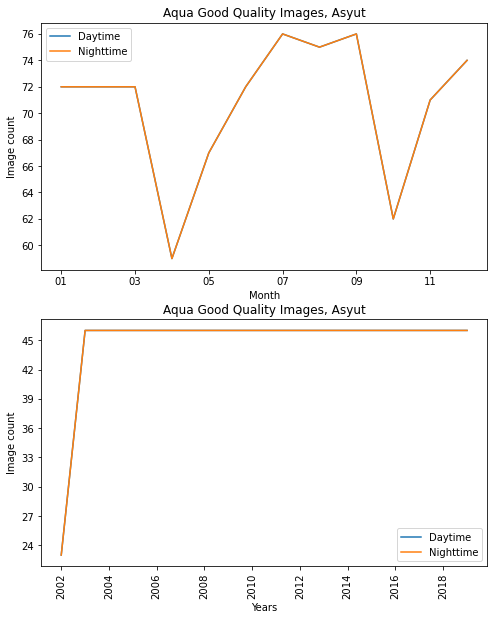

In [61]:
#Plot the data
plot_title = '{} Good Quality Images, {}'.format(satellite_name, City_name)

#Occurances of months daytime

mons = ['01','02','03','04','05','06','07','08','09','10','11','12']

mon_day_counts = [daytime_months.count('01'), daytime_months.count('02'), daytime_months.count('03'), daytime_months.count('04')
         , daytime_months.count('05'), daytime_months.count('06'), daytime_months.count('07'), daytime_months.count('08')
         , daytime_months.count('09'), daytime_months.count('10'), daytime_months.count('11'), daytime_months.count('12')]

mon_night_counts = [nighttime_months.count('01'), nighttime_months.count('02'), nighttime_months.count('03'), nighttime_months.count('04')
         , nighttime_months.count('05'), nighttime_months.count('06'), nighttime_months.count('07'), nighttime_months.count('08')
         , nighttime_months.count('09'), nighttime_months.count('10'), nighttime_months.count('11'), nighttime_months.count('12')]

years = ['2002','2003','2004','2005','2006','2007','2008','2009','2010','2011','2012','2013','2014','2015','2016',
        '2017', '2018', '2019']

yr_day_counts = [daytime_years.count('2002'), daytime_years.count('2003'), daytime_years.count('2004')
         , daytime_years.count('2005'), daytime_years.count('2006'), daytime_years.count('2007'), daytime_years.count('2008')
         , daytime_years.count('2009'), daytime_years.count('2010'), daytime_years.count('2011'), daytime_years.count('2012')
         , daytime_years.count('2013'), daytime_years.count('2014'), daytime_years.count('2015'), daytime_years.count('2016')
         , daytime_years.count('2017'), daytime_years.count('2018'), daytime_years.count('2019')]

yr_night_counts = [nighttime_years.count('2002'), nighttime_years.count('2003'), nighttime_years.count('2004')
         , nighttime_years.count('2005'), nighttime_years.count('2006'), nighttime_years.count('2007'), nighttime_years.count('2008')
         , nighttime_years.count('2009'), nighttime_years.count('2010'), nighttime_years.count('2011'), nighttime_years.count('2012')
         , nighttime_years.count('2013'), nighttime_years.count('2014'), nighttime_years.count('2015'), nighttime_years.count('2016')
         , nighttime_years.count('2017'), nighttime_years.count('2018'), nighttime_years.count('2019')]

fig, axes = plt.subplots(nrows = 2,ncols = 1, figsize=(8, 10))

axes[0].plot(mons, mon_day_counts, label='Daytime')
axes[0].plot(mons, mon_night_counts, label = 'Nighttime')
axes[0].set_title(plot_title)
axes[0].set(xlabel = 'Month', ylabel = 'Image count')
axes[0].legend()

axes[1].plot(years, yr_day_counts, label='Daytime')
axes[1].plot(years, yr_night_counts, label = 'Nighttime')
axes[1].set_title(plot_title)
axes[1].set(xlabel = 'Years', ylabel = 'Image count')
axes[1].legend()
plt.xticks(rotation=90)


xa = axes[0].get_xaxis()
xa.set_major_locator(MaxNLocator(integer=True)) 
ya = axes[0].get_yaxis()
ya.set_major_locator(MaxNLocator(integer=True)) 
xa = axes[1].get_xaxis()
xa.set_major_locator(MaxNLocator(integer=True))
ya = axes[1].get_yaxis()
ya.set_major_locator(MaxNLocator(integer=True)) 

#save the plot as a png
plotname = 'quality_images_{}_{}'.format(CITY_COUNTRY, SATELLITE)
plt.savefig(plotname)

In [62]:
#Save the images to csv files
csv_name_day = '{}_Quality_Images_Day.csv'.format(CITY_COUNTRY)
csv_name_night = '{}_Quality_Images_Night.csv'.format(CITY_COUNTRY)

day_df = pd.DataFrame(Day_list)
night_df = pd.DataFrame(Night_list)

day_df.to_csv(csv_name_day, index = False)
night_df.to_csv(csv_name_night, index = False)